[*********************100%***********************]  1 of 1 completed


/var/folders/hw/r_q5t6hd2r71fj7t3zwm74kc0000gn/T/ipykernel_51892/2846542498.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'close_smooth'] = explicit_heat_smooth(df['Close'].values, t_end=3)


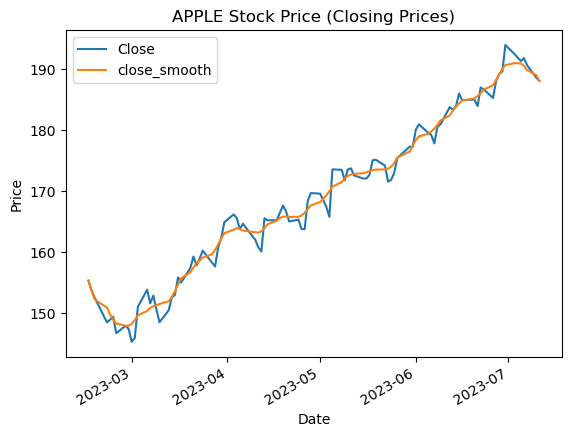

In [61]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def explicit_heat_smooth(prices: np.array, t_end: float=3.0) -> np.array:
    '''smoothening out a time series using a simple explicit finite difference method, using first order method
    in time, and second order centred difference approximation in space. stable if time step is 0<=k<=1
    
    the prices are fixed at the end-points so the interior is smoothed
    
    prices: np.array the prices to smoothen
    t_end: float is the time at which to terminate the smoothening (t=2)
    
    returns P: np.array the smoothened time series
    '''
    k = 0.2
    
    P = prices
    
    t = 0
    
    while t < t_end:
        #solve the finite difference scheme for the next time-step
        P = k*(P[2:] + P[:-2]) + P[1:-1]*(1-2*k)
        
        P = np.hstack((
            np.array([prices[0]]),
            P,
            np.array([prices[-1]]),
        ))
        t += k
    return P

if __name__ == '__main__':
    df = yf.download('AAPL')
    
    #start_date = '2019-01-01'
    #end_date = '2023-06-01'
    #symbol = 'AAPL'
    #df_AAPL = yf.download(symbol, start_date, end_date)
    #df_AAPL
    
    df = df[-100:]
    
    df.loc[:,'close_smooth'] = explicit_heat_smooth(df['Close'].values, t_end=3)
    
    df.plot(y = ['Close', 'close_smooth'], xlabel='Date', ylabel='Price', title='APPLE Stock Price (Closing Prices)')

In [62]:
def heat_analytical_smooth(prices: np.array, t: float = 3.0, m: int=200) -> np.array:
    '''
    Find the analytical soln to the heat equ
    
    prices: np.array the price to smoothen
    
    t: float the time at which to terminate the smoothening (t=2)
    
    m: int the amount of terms in the solution's fourier series
    
    will return np.array of the analytical solution to the heat equ
    '''
    
    p0 = prices[0]
    pn = prices[-1]
    
    n = prices.shape[0]
    x = np.arange(0, n, dtype = np.float32)
    M = np.arange(1, m, dtype = np.float32)
    
    L = n-1
    u_e = p0 + (pn - p0) * x / L
    
    mx = M.reshape(-1, 1)@x.reshape(1, -1)
    sin_m_pi_x = np.sin(mx*np.pi/L)
    
    #calculate the B_m terms using numerical quadrature (trapezium rule)
    bm = 2*np.sum((sin_m_pi_x*(prices-u_e)).T, axis = 0)
    
    return u_e + np.sum((bm*np.exp(-t*(M*np.pi/L)**2)).reshape(-1,1)*sin_m_pi_x, axis=0)


In [63]:
import time
import numba as nb

from scipy.signal import savgol_filter
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

@nb.jit(nopython = True)

def explicit_heat_smooth(prices: np.array, t_end: float=3.0) -> np.array:
    '''smoothening out a time series using a simple explicit finite difference method, using first order method
    in time, and second order centred difference approximation in space. stable if time step is 0<=k<=1
    
    the prices are fixed at the end-points so the interior is smoothed
    
    prices: np.array the prices to smoothen
    t_end: float is the time at which to terminate the smoothening (t=2)
    
    returns P: np.array the smoothened time series
    '''
    k = 0.1
    
    P = prices
    
    t = 0
    
    while t < t_end:
        #solve the finite difference scheme for the next time-step
        P = k*(P[2:] + P[:-2]) + P[1:-1]*(1-2*k)
        
        P = np.hstack((
            np.array([prices[0]]),
            P,
            np.array([prices[-1]]),
        ))
        t += k
    return P

def smooth_heat(vals_to_smooth: np.array):
    
    for n in range(vals_to_smooth.shape[0]):
        vals_to_smooth[n, :] = explicit_heat_smooth(vals_to_smooth[n, :], t_end = 3)
    return vals_to_smooth

def savgol_smooth(vals_to_smooth: np.array):
    for n in range(vals_to_smooth.shape[0]):
        vals_to_smooth[n, :] = savgol_filter(vals_to_smooth[n, :], 11, 5)
        
    return vals_to_smooth

def get_time_series(df, col, name, lags):
    '''
    getting time series of data and placing them as new columns
    '''
    
    return df.assign(**{
        f'{name}_t-{lag}': df[col].shift(lag)
        for lag in lags
    })

if __name__ == '__main__':
    df = yf.download('AAPL')
    df = (get_time_series(df, "Close", 'close', range(100))
         .dropna()
         .drop(columns = ['Open', 'Low', 'High', 'Close', "Adj Close", 'Volume'])
    )
    
    vals_to_smooth = df.values
    
    t0 = time.time()
    heat_equ = smooth_heat(vals_to_smooth)
    print('Heat Equation smooth time: ', time.time()-t0)
    
    t0 = time.time()
    heat_equ = savgol_smooth(vals_to_smooth)
    print('Savitzky Golay smooth time: ', time.time()-t0)
    

[*********************100%***********************]  1 of 1 completed
Heat Equation smooth time:  1.2163808345794678
Savitzky Golay smooth time:  2.2925209999084473
